# Obtaining scientific data

In order to carry out evidence synthesis, we need to get our hands on data from bibliographic databases. There a multitude of different databases out there: some are general, while others are specific to a particular discipline. Some focus solely on peer-reviewed journals, while others may focus on, or also contain, preprints, conference proceedings, scientific reports, PhD theses, or other "grey" literature sources (for an overview of available databases and their disciplinary coverage check out [Gusenbauer, 2022](https://link.springer.com/article/10.1007/s11192-022-04289-7). In evidence synthesis projects, comprehensiveness is important, so searching as many relevant databases *as is practicable* is usually seen as best practice.  

![image](images/OpenAlex-logo-5.2de7053c.png)

In this tutorial, we are going to use a relatively new database called [OpenAlex](https://openalex.org/). This database attempts to be as comprehensive as possible. It has some limitations in how you can search, but it does have an open (and importantly unlimited) API, and is free and open source. Because of the search limitations it will not (easily) a full reproduction of our previous study, but this is the best we can do with a single open-access resource. In future evidence synthesis projects you should consider the full breadth of available open and proprietary resources.


## Translating a boolean query into an API call for OpenAlex

We usually search for literature with "Boolean queries", which are lists of search terms joined by "AND" and "OR" operators. Most commonly we will have one or more "blocks" of terms capturing different concepts, which we link with "AND" operators, such that we demand that results contain one or matches from each block. Terms within blocks are linked by "OR" operators. In our example, we have three blocks: one related to climate, one related to impacts, and one related to attribution (the query was developed by adding words to the query until it returned every available record from a list of references known to be relevant through their use in a previous IPCC report section on attributable climate impacts). In the cells below we use a little bit of regex to turn a boolean query of this type into the url string required by OpenAlex.

In [1]:
import re

# Here we define the 3 concept groups we want to link by AND operators
concept_groups = [
    ''' "climate" OR elevated temperature" OR 
    "ocean warming" OR "saline intrusion" OR 
    "environmental change" OR "global warming" OR     
    "global change" OR "greenhouse effect" OR 
    "snow cover" OR "extreme temperature" OR 
    "cyclone" OR "ocean acidification" OR "anthropogenic" 
    OR "sea level" OR "precipitation variability" 
    OR "precipitation change" OR "temperature impact" OR 
    "environmental variability" OR "weather pattern" OR 
    "weather factor" OR "increase in temperature") ''',    
    ''' "species" OR
    "mortality" OR "health" OR
    "disease" OR "ecosystem" OR
    "mass balance" OR "flood" OR
    "drought" OR "disease" OR
    "adaptation" OR "malaria" OR "fire"
    OR "water scarcity" OR "water
    supply" OR "permafrost" OR
    "biological response" OR "food
    availability" OR "food security" OR
    "vegetation dynamic" OR "cyclone"
    OR "yield" OR "gender" OR
    "indigenous" OR "conflict" OR
    "inequality" OR "snow water
    equivalent" OR "surface temperature" OR
    "glacier melt" OR
    "glacier mass" OR
    "coastal erosion" OR
    "glacier retreat" OR
    "rainfall reduction" OR
    "reduction in rainfall" OR
    "coral stress" OR "precipitation
    increase" OR "precipitation decrease"
    OR "river flow" ''',
    ''' "recent" OR "current" OR "modern" OR "observation" OR
    "observed" OR "observable"
    "evidence" OR "past" OR "local" OR "regional" OR 
    "significant" OR "driver" OR "driving" OR 
    "response" OR "were responsible" OR "was responsible" OR 
    "exhibited" OR "witnessed" OR "attribution" OR
    "attributed" OR "attributable" OR 
    "has increased" OR "has decreased" OR 
    "historic" OR "correlation" OR "evaluation" '''
]

def query_to_openalex_url(concept_groups, field):

    query_strings = []
    for concept_group in concept_groups:
        # For each group, remove superfluous white space, replace ORs with |, and replace URL encode the spaces
        query_string = re.sub(" +"," ",concept_group.strip().replace("\n"," ")).replace(" OR ","|").replace(" ","%20")
        # Add this string to a list with the field to be searched (currently titles can be searched but abstract search
        # cannot be done with the same boolean search process)
        query_strings.append(f"{field}.search:{query_string}") 

    # For the final url, we just need to link these strings with a comma, which is equivalent 
    # to the AND operator
    return "https://api.openalex.org/works?filter="+",".join(query_strings)+"&per-page=200"

url = query_to_openalex_url(concept_groups,"title")
print(url)


https://api.openalex.org/works?filter=title.search:"climate"|elevated%20temperature"|"ocean%20warming"|"saline%20intrusion"|"environmental%20change"|"global%20warming"|"global%20change"|"greenhouse%20effect"|"snow%20cover"|"extreme%20temperature"|"cyclone"|"ocean%20acidification"|"anthropogenic"|"sea%20level"|"precipitation%20variability"|"precipitation%20change"|"temperature%20impact"|"environmental%20variability"|"weather%20pattern"|"weather%20factor"|"increase%20in%20temperature"),title.search:"species"|"mortality"|"health"|"disease"|"ecosystem"|"mass%20balance"|"flood"|"drought"|"disease"|"adaptation"|"malaria"|"fire"|"water%20scarcity"|"water%20supply"|"permafrost"|"biological%20response"|"food%20availability"|"food%20security"|"vegetation%20dynamic"|"cyclone"|"yield"|"gender"|"indigenous"|"conflict"|"inequality"|"snow%20water%20equivalent"|"surface%20temperature"|"glacier%20melt"|"glacier%20mass"|"coastal%20erosion"|"glacier%20retreat"|"rainfall%20reduction"|"reduction%20in%20rai

Try and generate your own query using the method given above. 

Enter your query url into your browser. Is the query valid? How many results does it return?

## Getting results with the OpenAlex API

In [2]:
import requests
import json

from sensitive_variables import email
headers = {}
if email is not None:
    headers["email"] = email

r = requests.get(url, headers = headers)
res = r.json()
    
print(res["meta"])

{'count': 13407, 'db_response_time_ms': 1223, 'page': 1, 'per_page': 200}


The "meta" object tells us that there are > 10,000 results for this query. To get them all we'll have to do pagination using [Cursor paging](https://docs.openalex.org/api#cursor-paging). But first let's have a look at what the results look like, so we know what to do with them.

In [3]:
work = res["results"][0]
work

{'id': 'https://openalex.org/W2076977109',
 'doi': 'https://doi.org/10.1038/nature03906',
 'title': 'Increasing destructiveness of tropical cyclones over the past 30 years',
 'display_name': 'Increasing destructiveness of tropical cyclones over the past 30 years',
 'relevance_score': 1477.6027,
 'publication_year': 2005,
 'publication_date': '2005-08-04',
 'ids': {'openalex': 'https://openalex.org/W2076977109',
  'doi': 'https://doi.org/10.1038/nature03906',
  'mag': '2076977109',
  'pmid': 'https://pubmed.ncbi.nlm.nih.gov/16056221'},
 'host_venue': {'id': 'https://openalex.org/V137773608',
  'issn_l': '0028-0836',
  'issn': ['1476-4687', '0028-0836'],
  'display_name': 'Nature',
  'publisher': 'Springer Nature',
  'type': 'publisher',
  'url': 'https://doi.org/10.1038/nature03906',
  'is_oa': False,
  'version': None,
  'license': None},
 'type': 'journal-article',
 'open_access': {'is_oa': False, 'oa_status': 'closed', 'oa_url': None},
 'authorships': [{'author_position': 'first',
  

For our purposes, we just want a csv with a row for each record and some basic info like title, abstract, authorship, and publication year. For copyright reasons, the abstract is stored in an inverted index, so we use a little function ([thank you Sruthi V on stackoverflow](https://stackoverflow.com/questions/72093757/running-python-loop-to-iterate-and-undo-inverted-index)) to put this back together

In [4]:
# Source https://stackoverflow.com/questions/72093757/running-python-loop-to-iterate-and-undo-inverted-index 
# (slightly amended for performance and simplicity)
def uninvert_abstract(aii):
    if aii is None:
        return None
    word_index = list(aii.items())
    word_index = sorted(word_index,key = lambda x : x[1])
    return " ".join(map(lambda x : x[0], word_index))

uninvert_abstract(work["abstract_inverted_index"])

'Theory and modelling predict that hurricane intensity should increase with increasing global mean temperatures, but work on the detection of trends in activity has focused mostly their frequency shows no trend. Here I define an index potential destructiveness hurricanes based total dissipation power, integrated over lifetime cyclone, show this increased markedly since mid-1970s. This trend is due to both longer storm lifetimes greater intensities. find record net power highly correlated tropical sea surface temperature, reflecting well-documented climate signals, including multi-decadal oscillations North Atlantic Pacific, warming. My results suggest future warming may lead upward cyclone destructive potential, and--taking into account coastal population--a substantial hurricane-related losses twenty-first century.'

In [5]:
# Now we will cycle through the works and put them into a list of dicts, then turn that into a dataframe
import pandas as pd

keep_fields = ["id","doi","title","publication_year",]

def result_list(results, keep_fields):
    work_dicts = []
    for work in results:
        # Get the basic fields we want
        work_min =  { k: work[k] for k in keep_fields }
        # uninvert the abstract
        work_min["abstract"] = uninvert_abstract(work["abstract_inverted_index"])
        # put the authors into a single string
        authors = [author["author"]["display_name"] for author in work["authorships"]]
        work_min["authors"] = ", ".join([a for a in authors if a is not None])
        work_dicts.append(work_min)

    return work_dicts

df = pd.DataFrame.from_dict(result_list(res["results"], keep_fields))
df.head()

,id,doi,title,publication_year,abstract,authors
0,https://openalex.org/W2076977109,https://doi.org/10.1038/nature03906,Increasing destructiveness of tropical cyclone...,2005,Theory and modelling predict that hurricane in...,Kerry Emanuel
1,https://openalex.org/W2171979944,https://doi.org/10.1007/s00425-003-1105-5,"Plant responses to drought, salinity and extre...",2003,"Abiotic stresses, such as drought, salinity, e...","Wangxia Wang, Basia Vinocur, Arie Altman"
2,https://openalex.org/W2122582889,https://doi.org/10.1073/pnas.0505734102,Regional vegetation die-off in response to glo...,2005,Future drought is projected to occur under war...,"David D. Breshears, Neil S. Cobb, Paul M. Rich..."
3,https://openalex.org/W2101875448,None,INTRODUCED SPECIES: A SIGNIFICANT COMPONENT OF...,1997,Humans move species beyond their native ranges...,"Peter M. Vitousek, Carla M. D'Antonio, Lloyd L..."
4,https://openalex.org/W2161828152,https://doi.org/10.1073/pnas.0901438106,Temperature sensitivity of drought-induced tre...,2009,Large-scale biogeographical shifts in vegetati...,"Henry D. Adams, Maite Guardiola-Claramonte, Gr..."


In [6]:
def get_paginated_results(url, directory, max_requests, headers):
    next_cursor = "*"
    n_requests = 0
    works_list = []
    while next_cursor is not None:
        n_requests+=1
        if n_requests > max_requests:
            break
        if n_requests % 5 == 1:
            print(f"getting url {n_requests}")
        cursor_url = url + f"&cursor={next_cursor}" 
        r = requests.get(cursor_url, headers=headers)
        res = r.json()
        if len(res["results"]) > 0:
            if directory is not None: # if a directory is provided, save the results there
                with open(f"{directory}/results_{n_requests}.json","w") as f: 
                    json.dump(res["results"],f)
            works_list += result_list(res["results"], keep_fields)
        next_cursor = res["meta"]["next_cursor"]
    return works_list
    
directory = "OpenAlex_data/q1"
works_list = get_paginated_results(url, directory, np.Inf, headers) 
df = pd.DataFrame.from_dict(works_list)
print(df.shape)
df.to_csv("data/openalex_data.csv",index=False)
df.head()

In [ ]:
# Now we need to do the same for abstract search
## NEEDS SOME TIME TO RUN
# url = query_to_openalex_url(concept_groups,"abstract")
# directory = "OpenAlex_data/q1_abstracts"
# works_list = get_paginated_results(url, directory, 10000000, headers) 
# df = pd.DataFrame.from_dict(works_list)
# print(df.shape)
# df.to_csv("data/openalex_data_abstracts.csv",index=False)
# df.head()

Great! now we've got all the documents in a format that's easy to work with, as well as detailed info including citations and institutions saved in jsons

## Basic exploration
Now that we have the data in a convenient format, we can begin to explore the data, e.g. by plotting the number of publications in each year

(13359, 6)


<AxesSubplot:xlabel='publication_year'>

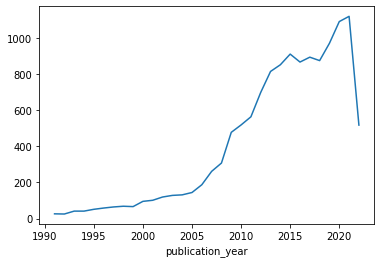

In [306]:
print(df.shape)
df.query("publication_year>1990").groupby("publication_year")["id"].count().plot()